In [1]:
import numpy as np
import scipy as sp

from typing import List, Set, Tuple

Testing out a new way to index every cell in the multiple level arrays

Expect quadrants to be indexed as 0123 from bottom left, to bottom right, to top left, to top right
(Hence to the output of the matricies in pure number form are actually x down, y right)

# Index Matricies

Functions to get:
* Children
* Parent
* Nearest Neighbour
* Interaction List
For a given set of coordinates in a given level

Also generator function for a list of index matricies to test out on.

In [2]:
def create_index_matricies(max_level:int):
    max_level = 3

    return [np.arange(4**l).reshape((2**l, 2**l)).transpose() for l in range(max_level+1)]


def get_children(parent_coords:Tuple[int]) -> List[Tuple[int]]:
    x, y = parent_coords
    return [
        (x*2, y*2),
        (x*2+1, y*2),
        (x*2, y*2+1),
        (x*2+1, y*2+1)
    ]

def parent(child_coords:Tuple[int]) -> Tuple[int]:
    return (child_coords[0]//2, child_coords[1]//2)


def nearest_neighbours(coords:Tuple[int], level:int) -> Set[Tuple[int]]:
    if level == 0:
        return set()

    x,y = coords
    max_coord = 2**level - 1
    neighbours = set()

    # middle row x_n = x
    if y != 0:
        neighbours.add((x,y-1))
    if y != max_coord:
        neighbours.add((x,y+1))

    # left row x_n = x-1
    if x !=0:
        neighbours.add((x-1,y))
        if y != 0:
            neighbours.add((x-1,y-1))
        if y != max_coord:
            neighbours.add((x-1,y+1))

    # right row x_n = x+1
    if x != max_coord:
        neighbours.add((x+1,y))
        if y != 0:
            neighbours.add((x+1,y-1))
        if y != max_coord:
            neighbours.add((x+1,y+1))
    
    return neighbours

def interaction_list(cell_coords:Tuple[int], level:int) -> Set[Tuple[int]]:
    if level <= 1:
        return set()
    
    own_neighbours = nearest_neighbours(cell_coords, level)
    parent_neighbours = nearest_neighbours(parent(cell_coords), level-1)
    all_possible = set()
    for p_n in parent_neighbours:
        all_possible.update(get_children(p_n))

    return all_possible - own_neighbours

In [3]:
max_level = 3

index_matricies = create_index_matricies(max_level)

In [4]:
cell = (1,0)
print(index_matricies[2][cell])
print({index_matricies[2][interactor] for interactor in interaction_list(cell,2)})

# weirdness is to output as expected, ie in xy coordinates
# [matrix for matrix in level_matricies]
[np.flip(np.transpose(matrix), 0) for matrix in index_matricies]

1
{3, 7, 8, 9, 10, 11, 12, 13, 14, 15}


[array([[0]]),
 array([[2, 3],
        [0, 1]]),
 array([[12, 13, 14, 15],
        [ 8,  9, 10, 11],
        [ 4,  5,  6,  7],
        [ 0,  1,  2,  3]]),
 array([[56, 57, 58, 59, 60, 61, 62, 63],
        [48, 49, 50, 51, 52, 53, 54, 55],
        [40, 41, 42, 43, 44, 45, 46, 47],
        [32, 33, 34, 35, 36, 37, 38, 39],
        [24, 25, 26, 27, 28, 29, 30, 31],
        [16, 17, 18, 19, 20, 21, 22, 23],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [ 0,  1,  2,  3,  4,  5,  6,  7]])]

# Actual FMM

Create list of all the matricies of the various multipole and local expansions
These will be 3D matricies with dimensions of $(2^l, 2^l, 2p)$ where $l$ is the level and $p$ is the global precision for each expansion

In [5]:
from fmm import Particle

In [6]:
def create_expansion_matricies(max_level:int, precision:int):
    """Returns a list of matricies for the expansion coefficients to be placed into
    
    For each 'cell' the first value also stores the complex centre of that cell
    """

    expansion_matricies = [np.zeros((2**l,2**l,2*precision+1), dtype=complex) for l in range(max_level+1)]
    for l, matrix in enumerate(expansion_matricies):
        first_val = 1/(2**(l+1))
        # stop of 1 as this is the so called max value, but will never appear
        vals = np.arange(first_val,1,2*first_val)
        X,Y = np.meshgrid(vals, vals, indexing='ij')
        matrix[:,:,0] = X + 1j*Y
    
    return expansion_matricies

def get_particle_cell(particle:Particle, level:int) -> Tuple[int]:
    return (
        int(particle.centre.real * 2**level),
        int(particle.centre.imag * 2**level)
    )

In [7]:
def calculate_multipole(particle:Particle, cell:Tuple[int], precision:int, level:int, matrix) -> None:
    """Update the relevant cell in given level with multipole due to particle
    
    Parameters
    ----------
    particle : Particle
        particle whose effect to add
    cell : Tuple[int]
        particles cell coords
    precision : int
        precision in multipole expansion
    level : int
        the level at which to add the particle's effect
    matrix : NDArray
        the full matrix for the relevant level
    """

    matrix[cell][1] = particle.charge
    k = np.arange(1,precision,1)
    matrix[cell][2:precision+1] += -particle.charge * (particle.centre - matrix[cell[0],cell[1],0])**k / k

def cell_M2M(cell:Tuple[int], child:Tuple[int], precision:int, matrix, children_matrix):
    """M2M from children for a single cell"""

    child_multipole = children_matrix[child][1:precision+1]

    matrix[cell][1] += child_multipole[0]

    z0 = children_matrix[child][0] - matrix[cell][0]

    for l in range(1,precision):
        k = np.arange(1,l+1)
        matrix[cell][l+1] += -(child_multipole[0] * z0**l / l) \
            + np.sum(child_multipole[1:l+1] \
                        * z0**(l-k) * sp.special.binom(l-1,k-1))

def level_M2M(precision:int, level:int, matrix, children_matrix) -> None:
    """Perform M2M on a given level due to the multipoles in the child level"""
    # Can definitely optimise the way this is done
    for x in range(2**level):
        for y in range(2**level):
            for child in get_children((x,y)):
                cell_M2M((x,y),child,precision,matrix,children_matrix)

def cell_M2L(cell:Tuple[int], interactor:Tuple[int], precision:int, matrix) -> None:
    """Local expansion of a cell due to interactor"""

    z0 = matrix[interactor][0] - matrix[cell][0] # local expansion 'about origin' (so about cell)

    minus_and_plus = np.empty(precision-1)
    minus_and_plus[::2] = -1
    minus_and_plus[1::2] = 1

    k_vals = np.arange(1, precision)
    l_vals = np.arange(1, precision)

    interactor_multipole = matrix[interactor][1:precision+1]

    minus_bk_over_z0k = minus_and_plus * interactor_multipole[1:] / z0**k_vals

    matrix[cell][precision+1] += interactor_multipole[0] * np.log(-z0) + np.sum(minus_bk_over_z0k)
    matrix[cell][precision+2:] += -interactor_multipole[0] / (l_vals * z0**l_vals) \
                    + (1/z0**l_vals) * np.sum(minus_bk_over_z0k * sp.special.binom(l_vals[:,np.newaxis] + k_vals - 1, k_vals-1), axis=1)
    
def level_M2L(precision:int, level:int, matrix) -> None:
    """Do M2L for a given level"""

    for x in range(2**level):
        for y in range(2**level):
            for interactor in interaction_list((x,y),level):
                cell_M2L((x,y),interactor,precision,matrix)

def cell_L2L(cell:Tuple[int], child:Tuple[int], precision:int, matrix, child_matrix) -> None:
    """Distribute local expansion to child cells"""
    
    z0 = child_matrix[child][0] - matrix[cell][0]

    k_vals = np.arange(1,precision)
    
    cell_local = matrix[cell][precision+2:] # does not include l=0 of cell's local

    for l in range(precision):
        child_matrix[child][precision+1+l] += np.sum(cell_local * sp.special.binom(k_vals,l) * z0**(k_vals-l))

def level_L2L(precision:int, level:int, matrix, child_matrix) -> None:
    """Distribute all locals in a given level to children level"""

    for x in range(2**level):
        for y in range(2**level):
            for child in get_children((x,y)):
                cell_L2L((x,y), child, precision, matrix, child_matrix)


In [71]:
def insert_particles(finest_matrix, max_level, particles:List[Particle], precision:int) -> List[List[Set[Particle]]]:
    finest_particles = [[set() for _ in range(2**max_level)] for _ in range(2**max_level)]
    for particle in particles:
        cell = get_particle_cell(particle, max_level)
        calculate_multipole(particle, cell, precision, max_level, finest_matrix)
        finest_particles[cell[0]][cell[1]].add(particle)
    
    return finest_particles

def upward_pass(precision:int, max_level:int, expansion_matricies):
    for level in range(max_level-1, -1, -1):
        level_M2M(precision, level, expansion_matricies[level], expansion_matricies[level+1])

def downward_pass(precision:int, max_level, expansion_matricies):
    """Perform downward pass"""
    # first two levels have zero local, as no interaction list
    # and don't want L2L for finest level
    for level in range(2, max_level):
        level_M2L(precision, level, expansion_matricies[level])
        level_L2L(precision, level, expansion_matricies[level], expansion_matricies[level+1])
    level_M2L(precision, max_level, expansion_matricies[max_level])

def get_particle_potentials(precision:int, max_level:int, finest_particles:List[List[Set[Particle]]], finest_matrix):
    for x, ys in enumerate(finest_particles):
        for y, elem in enumerate(ys):
            
            if not finest_particles[x][y]:
                continue

            cell_centre = finest_matrix[x,y,0]
            local = finest_matrix[x,y,precision+1:]
            l_vals = np.arange(len(local))

            near_particles = set()
            for neighbour_set in [finest_particles[xn][yn] for xn,yn in nearest_neighbours((x,y), max_level)]:
                near_particles.update(neighbour_set)
            near_particles.update(elem)

            for particle in elem:
                # far field expansion contribution
                z0 = particle.centre - cell_centre
                particle.potential -= np.sum(local * z0**l_vals).real

                # near-field
                for other_particle in near_particles-{particle}:
                    print(particle, other_particle)
                    particle.potential -= other_particle.charge * np.log(abs(particle.centre-other_particle.centre))



In [9]:
def direct_particle_potentials(particles:List[Particle]):
    for particle in particles:
        particle.direct_potential = 0.0

    for i, particle in enumerate(particles):
        for other in particles[i+1:]:
            potential = - np.log(abs(particle.centre-other.centre))
            particle.direct_potential += other.charge * potential
            other.direct_potential += particle.charge * potential

In [65]:
max_level = 2
precision = 4
num_particles = 4

expansion_matricies = create_expansion_matricies(max_level, precision)

particles = [Particle() for _ in range(num_particles)]
# particles = [
#     Particle(2, 0.15+0.2j),
#     Particle(-1, 0.9+0.8j)
# ]

In [72]:
finest_particles = insert_particles(expansion_matricies[max_level], max_level, particles, precision)
upward_pass(precision, max_level, expansion_matricies)
downward_pass(precision, max_level, expansion_matricies)
get_particle_potentials(precision, max_level, finest_particles, expansion_matricies[max_level])

Particle: (0.006360597322628059+0.23280624779175296j), charge -0.10801106503445146 Particle: (0.2314131712801778+0.468863361581512j), charge 0.6933185296551874
Particle: (0.2314131712801778+0.468863361581512j), charge 0.6933185296551874 Particle: (0.006360597322628059+0.23280624779175296j), charge -0.10801106503445146
Particle: (0.02398802725473781+0.8403820883507621j), charge -0.8603876116026914 Particle: (0.11440433144495088+0.9487335824870944j), charge -0.8745121237956852
Particle: (0.11440433144495088+0.9487335824870944j), charge -0.8745121237956852 Particle: (0.02398802725473781+0.8403820883507621j), charge -0.8603876116026914


In [69]:
direct_particle_potentials(particles)

potentials = [particle.potential for particle in particles]
direct_potentials = [particle.direct_potential for particle in particles]

potential_err = list(np.array(potentials) - np.array(direct_potentials))

print([particle.centre for particle in particles])
print('Dir:', direct_potentials)
print('FMM:', potentials)
print('Err:', potential_err)
print([abs(err) > 1e-4 for err in potential_err])

[(0.2314131712801778+0.468863361581512j), (0.11440433144495088+0.9487335824870944j), (0.02398802725473781+0.8403820883507621j), (0.006360597322628059+0.23280624779175296j)]
Dir: [-1.473054537391954, -1.2305948627517738, -1.1737569457465096, 0.06605465869681981]
FMM: [-1.8603957737357852, -1.915163400293837, -1.7515280516653398, 0.5662311489314553]
Err: [-0.38734123634383133, -0.6845685375420631, -0.5777711059188302, 0.5001764902346355]
[True, True, True, True]


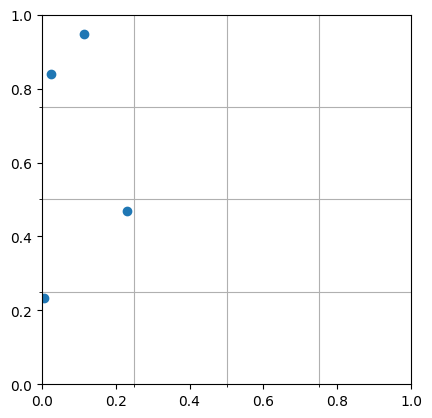

In [70]:
import matplotlib.pyplot as plt

X = [particle.centre.real for particle in particles]
Y = [particle.centre.imag for particle in particles]
ticks = np.arange(0,1,2*expansion_matricies[max_level][0,0,0].real)

fig, ax = plt.subplots()
ax.plot(X,Y, 'o')
ax.set_aspect('equal')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xticks(ticks, minor=True)
ax.set_yticks(ticks, minor=True)
ax.grid(True, 'minor')
plt.show()

In [13]:
particles = [
    Particle(2,(0.11+0.22j)),
    Particle(-1.5, (0.93+0.81j))
]

precision = 4
max_level = 2

expansion_matricies = create_expansion_matricies(max_level, precision)

finest_particles = insert_particles(expansion_matricies[max_level], max_level, particles, precision)

upward_pass(precision, max_level, expansion_matricies)

expansion_matricies[-1][0,0,1:precision+1], expansion_matricies[-1][3,3,1:precision+1]

(array([ 2.000e+00+0.j        ,  3.000e-02-0.19j      ,
         8.800e-03+0.00285j   , -2.685e-04+0.00052883j]),
 array([-1.50000e+00+0.j        ,  8.25000e-02-0.0975j    ,
        -9.00000e-04-0.0053625j , -2.65375e-04-0.00015763j]))

In [14]:
expansion_matricies[1][0,0,1:precision+1], expansion_matricies[1][1,1,1:precision+1], expansion_matricies[0][0,0,1:precision+1]

(array([ 2.00000000e+00+0.j      ,  2.80000000e-01+0.06j    ,
        -1.87000000e-02-0.0084j  ,  1.57733333e-03+0.001158j]),
 array([-1.5     +0.j      ,  0.27    +0.09j    ,  0.0216  +0.0162j  ,
         0.001944+0.002808j]),
 array([ 0.5     +0.j        ,  1.425   +1.025j     ,
        -0.0071  -0.01845j   , -0.043837+0.14162433j]))

In [15]:
downward_pass(precision, max_level, expansion_matricies)

expansion_matricies[-1][0,0,precision+1:], expansion_matricies[-1][3,3,precision+1:]

(array([-0.0831678 +3.65484107j,  1.08074874-0.91961807j,
         0.10746311-0.6625039j , -0.2190231 -0.36206705j]),
 array([ 0.0141222 +1.41615317j,  1.50863763-1.29160573j,
        -0.15205241+0.97442818j, -0.34309736-0.55583605j]))

In [16]:
get_particle_potentials(precision, max_level, finest_particles, expansion_matricies[max_level])
[particle.potential for particle in particles]

[(-0.015224542072767822+3.7768581521370224j),
 (0.0202993894303571+1.2473744376635567j)]

In [17]:
expansion_matricies = create_expansion_matricies(3,4)
centres = [matrix[:,:,0] for matrix in expansion_matricies]

cell = (0,1)
expansion_matricies[1][cell[0], cell[1], 2:5]

[np.flip(np.transpose(matrix), 0) for matrix in centres]

[array([[0.5+0.5j]]),
 array([[0.25+0.75j, 0.75+0.75j],
        [0.25+0.25j, 0.75+0.25j]]),
 array([[0.125+0.875j, 0.375+0.875j, 0.625+0.875j, 0.875+0.875j],
        [0.125+0.625j, 0.375+0.625j, 0.625+0.625j, 0.875+0.625j],
        [0.125+0.375j, 0.375+0.375j, 0.625+0.375j, 0.875+0.375j],
        [0.125+0.125j, 0.375+0.125j, 0.625+0.125j, 0.875+0.125j]]),
 array([[0.0625+0.9375j, 0.1875+0.9375j, 0.3125+0.9375j, 0.4375+0.9375j,
         0.5625+0.9375j, 0.6875+0.9375j, 0.8125+0.9375j, 0.9375+0.9375j],
        [0.0625+0.8125j, 0.1875+0.8125j, 0.3125+0.8125j, 0.4375+0.8125j,
         0.5625+0.8125j, 0.6875+0.8125j, 0.8125+0.8125j, 0.9375+0.8125j],
        [0.0625+0.6875j, 0.1875+0.6875j, 0.3125+0.6875j, 0.4375+0.6875j,
         0.5625+0.6875j, 0.6875+0.6875j, 0.8125+0.6875j, 0.9375+0.6875j],
        [0.0625+0.5625j, 0.1875+0.5625j, 0.3125+0.5625j, 0.4375+0.5625j,
         0.5625+0.5625j, 0.6875+0.5625j, 0.8125+0.5625j, 0.9375+0.5625j],
        [0.0625+0.4375j, 0.1875+0.4375j, 0.3125+0.4375